<h2 style = "font-family: garamond; font-size: 50px; font-style: normal; letter-spcaing: 3px; background-color:#36609A ; color :#FFCE30 ; border-radius: 5px 5px; padding:10px;text-align:center; font-weight: bold" >Detection of Helicobacter Pylori Infection by Machine Learning Using Routine Blood Tests<br/></h2 > 
<h2 style = "font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spcaing: 2px; background-color:#36609A; color : #FFCE30 ; border-radius: 5px 5px; padding:3px;text-align:center; font-weight: bold" >Shiben Zhu, Xinyi Tan, He Huang, Yi Zhou, Yang Liu<br/>Dec 29, 2023<br/>Email: s1350048@live.hkmu.edu.hk</h2> 

<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">1. Environmental Setting</h2>

In [78]:
'''Setting'''
# Import necessary modules
import os  # Import the operating system module for file path and system functions
import webbrowser
import shap  # Import the SHAP library for model explanation
import warnings  # Import the warnings module to suppress warnings
import re  # Import the regular expressions module for string manipulation
import time  # Import the time module for time-related operations
import pandas as pd  # Import the Pandas library for data manipulation
import numpy as np  # Import the NumPy library for numerical computations
import matplotlib.pyplot as plt  # Import the Matplotlib library for plotting
import seaborn as sns  # Import the Seaborn library for statistical data visualization
import scipy.stats as stats  # Import the SciPy library for scientific computing and statistics
import torch  # Import the PyTorch library for deep learning
import torch.nn as nn  # Import the PyTorch neural network module
import torch.optim as optim  # Import the PyTorch optimizer module
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset  # Import PyTorch data handling modules
from scipy.stats import chi2_contingency  # Import the chi-squared contingency test from SciPy
from pathlib import Path  # Import the Path module for handling file paths
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Import data preprocessing modules
from sklearn.model_selection import train_test_split  # Import data splitting module
from sklearn.linear_model import SGDClassifier, LogisticRegression  # Import SGD and logistic regression classifiers
from sklearn.svm import SVC  # Import the Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier  # Import ensemble classifiers
from sklearn.naive_bayes import GaussianNB  # Import the Gaussian Naive Bayes classifier
from sklearn.neighbors import KNeighborsClassifier  # Import the K-nearest neighbors classifier
from sklearn.neural_network import MLPClassifier  # Import the Multi-layer Perceptron classifier
from xgboost import XGBClassifier  # Import the XGBoost classifier
from catboost import CatBoostClassifier  # Import the CatBoost classifier
from lightgbm import LGBMClassifier  # Import the LightGBM classifier
from sklearn.metrics import (roc_curve, roc_auc_score, f1_score, accuracy_score,
                             precision_score, confusion_matrix, classification_report,
                             auc, recall_score)  # Import evaluation metrics modules
warnings.filterwarnings("ignore")  # Ignore warning messages

# ANSI escape sequences for colors and styles
YELLOW = '\033[93m'  # Yellow text color
BOLD = '\033[1m'  # Bold text style
RESET = '\033[0m'  # Reset text color and style

<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">2. Data Preprocession</h2>

In [79]:
'''Data preprocession'''
# Data cleaning process begins here
# Set the desired directory for data
desired_directory = r'D:\OneDrive - Hong Kong Metropolitan University\2.Liuyang\20231229machine_learning_blood'
os.chdir(desired_directory)

# Read data from Excel file
file = "20210101-20230630C14.xls"
data_v0 = pd.read_excel(file)

# Select specific columns and rename them
selected_columns = data_v0.iloc[:, [1, 2, 4, 6]]
selected_columns.columns = ["gender", "age", "outcome", "exposure"]

# Map 'gender' values to 1 for '男' and 0 for '女'
selected_columns['gender'] = selected_columns['gender'].map({'男': 1, '女': 0})

# Create 'outcome' values based on '阴' and '阳'
selected_columns['outcome'] = selected_columns['outcome'].apply(lambda x: 0 if '阴' in x else (1 if '阳' in x else None))

# Define a regex pattern to extract data from 'exposure' column
pattern = r'\[(.*?)\:(.*?)\]'
selected_columns['exposure'] = selected_columns['exposure'].apply(lambda x: re.findall(pattern, x))

# Extract blood data into separate columns
blood = selected_columns['exposure'].apply(lambda x: pd.Series(dict(x)))

# Remove rows with invalid data
blood = blood[~blood.apply(lambda row: any(row.astype(str).str.contains(r'[ =R]')), axis=1)]

# Rename blood data columns
new_column_names = {'白细胞': 'WBC',
                    '淋巴细胞百分比': 'Lymph%',
                    '单核细胞百分比': 'Mono%',
                    '中性粒细胞百分比': 'Neut%',
                    '红细胞': 'RBC',
                    '血红蛋白': 'Hb',
                    '红细胞比积': 'Hct',
                    '平均红细胞体积': 'MCV',
                    '平均血红蛋白含量': 'MCH',
                    '平均血红蛋白浓度': 'MCHC',
                    '红细胞体积分布宽度': 'RDW',
                    '血小板': 'PLC',
                    '平均血小板体积': 'MPV',
                    '血小板体积分布宽度': 'PDW',
                    '嗜酸性粒细胞百分比': 'Eos%',
                    '嗜碱性粒细胞百分比': 'Baso%',
                    '血小板压积': 'PCT',
                    '超敏C反应蛋白': 'CRP',
                    '淋巴细胞绝对值': 'ALC',
                    '单核细胞绝对值': 'AMC',
                    '中性粒细胞绝对值': 'ANC',
                    '嗜酸性粒细胞绝对值': 'AEC',
                    '嗜碱性粒细胞绝对值': 'ABC'}
blood.rename(columns=new_column_names, inplace=True)

# Select columns to keep
columns_to_keep = ['WBC',
                   'RBC',
                   'Hb',
                   'ALC',
                   'AMC',
                   'ANC',
                   'AEC',
                   'ABC',
                   'Baso%',
                   'Eos%',
                   'Lymph%',
                   'Mono%',
                   'Neut%',
                   'PDW',
                   'Hct',
                   'MCV',
                   'MCH',
                   'MCHC',
                   'RDW',
                   'PLC',
                   'MPV',
                   'PCT',
                   'CRP']

blood = blood.loc[:, columns_to_keep]

# Merge cleaned dataframes
merged_df = pd.concat([selected_columns.iloc[:, :3], blood], axis=1)

# Drop rows with missing values
data_v1 = merged_df.dropna()

# Print and display the original dataset
print(BOLD + YELLOW + 'Original dataset:' + RESET)
display(data_v1)

# Save the cleaned data to a CSV file
data_v1.to_csv('20231230original_data.csv')

# Create copies of the cleaned dataset for further processing
data_v2 = data_v1.copy()
data_v3 = data_v1.copy()

# Define a function to process values in blood data
def process_value(value):
    if isinstance(value, str) and '<' in value:
        return 0
    elif isinstance(value, str) and '>' in value:
        return 9999
    else:
        match = re.match(r"(\d+\.\d+|\d+)\((\d+\.\d+|\d+)-(\d+\.\d+|\d+)\)", value)
        if match:
            main_val = float(match.group(1))
            lower_val = float(match.group(2))
            upper_val = float(match.group(3))
            return (main_val-lower_val)/(upper_val-lower_val)
        return value

# Process values in blood data columns
for column in data_v2.iloc[:, 3:]:
    data_v2[column] = data_v2[column].apply(process_value)

# Print and display the available dataset
print(BOLD + YELLOW + 'Available dataset:' + RESET)
display(data_v2)

# Save the cleaned data to a CSV file
data_v2.to_csv('20231230clean_data.csv', index=False)

# Define a function to extract the main value from blood data
def extract_main_value(value):
    if isinstance(value, str) and ('<' in value or '>' in value):
        return 0
    else:
        match = re.match(r"(\d+\.\d+|\d+)\((\d+\.\d+|\d+)-(\d+\.\d+|\d+)\)", value)
        if match:
            return float(match.group(1))
        return value

# Extract main values from blood data columns
for column in data_v3.iloc[:, 3:]:
    data_v3[column] = data_v3[column].apply(extract_main_value)

# Print and display the true dataset
print(BOLD + YELLOW + 'True dataset:' + RESET)
display(data_v3)

# Save the cleaned data to a CSV file
data_v3.to_csv('20231230true_data.csv', index=False)

Original dataset:


,gender,age,outcome,WBC,RBC,Hb,ALC,AMC,ANC,AEC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
0,1,48,0,4.73(3.5-9.5),4.44(4.3-5.8),147.5(130-175),2.00(1.1-3.2),0.40(0.1-0.6),2.00(1.8-6.3),0.30(0.02-0.52),...,17.24(14.8-17.2),0.432(0.4-0.5),97.26(82-100),33.20(27-34),341.30(316-354),13.64(11-16),135.5(125-350),9.05(5.0-11.0),0.123(0.17-0.35),<1.00(0-3)
1,1,56,0,6.67(3.5-9.5),5.09(4.3-5.8),140.9(130-175),2.00(1.1-3.2),0.40(0.1-0.6),3.90(1.8-6.3),0.30(0.02-0.52),...,16.32(14.8-17.2),0.442(0.4-0.5),86.74(82-100),27.69(27-34),319.20(316-354),13.18(11-16),360.2(125-350),6.94(5.0-11.0),0.250(0.17-0.35),<1.00(0-3)
2,0,66,0,4.04(3.5-9.5),4.53(3.8-5.1),140.0(115-150),0.88(1.1-3.2),0.28(0.1-0.6),2.83(1.8-6.3),0.03(0.02-0.52),...,15.80(14.8-17.2),0.426(0.35-0.45),94.10(82-100),30.90(27-34),329.00(316-354),13.20(11.5-14.8),184.0(125-350),9.20(5.0-11.0),0.169(0.17-0.35),0.02(0-3)
3,1,59,1,4.74(3.5-9.5),4.14(4.3-5.8),144.6(130-175),1.50(1.1-3.2),0.40(0.1-0.6),2.70(1.8-6.3),0.10(0.02-0.52),...,16.51(14.8-17.2),0.423(0.4-0.5),102.09(82-100),34.92(27-34),342.10(316-354),14.08(11-16),196.6(125-350),8.02(5.0-11.0),0.158(0.17-0.35),0.20(0-3)
4,0,71,0,5.56(3.5-9.5),4.19(3.8-5.1),128.6(115-150),1.50(1.1-3.2),0.30(0.1-0.6),3.50(1.8-6.3),0.20(0.02-0.52),...,16.10(14.8-17.2),0.384(0.35-0.45),91.83(82-100),30.73(27-34),334.70(316-354),13.17(11.5-14.8),239.3(125-350),8.01(5.0-11.0),0.192(0.17-0.35),0.51(0-3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,0,65,0,4.55(3.5-9.5),4.20(3.8-5.1),125.0(115-150),1.32(1.1-3.2),0.24(0.1-0.6),2.82(1.8-6.3),0.15(0.02-0.52),...,15.70(14.8-17.2),0.379(0.35-0.45),90.10(82-100),29.70(27-34),330.00(316-354),13.20(11.5-14.8),287.0(125-350),8.70(5.0-11.0),0.251(0.17-0.35),4.90(0-4)
1422,1,32,0,7.81(3.5-9.5),4.84(4.3-5.8),141.0(130-175),1.43(1.1-3.2),0.31(0.1-0.6),5.98(1.8-6.3),0.07(0.02-0.52),...,16.00(14.8-17.2),0.422(0.40-0.50),87.20(82-100),29.10(27-34),334.00(316-354),12.00(11-16),295.0(125-350),8.70(5.0-11.0),0.257(0.17-0.35),3.10(0-4)
1423,0,70,0,3.17(3.5-9.5),3.55(3.8-5.1),115.0(115-150),0.98(1.1-3.2),0.15(0.1-0.6),2.01(1.8-6.3),0.03(0.02-0.52),...,16.20(14.8-17.2),0.342(0.35-0.45),96.30(82-100),32.30(27-34),335.00(316-354),12.10(11.5-14.8),160.0(125-350),9.30(5.0-11.0),0.149(0.17-0.35),0.60(0-4)
1424,0,64,0,3.56(3.5-9.5),4.27(3.8-5.1),121.0(115-150),1.42(1.1-3.2),0.30(0.1-0.6),1.67(1.8-6.3),0.15(0.02-0.52),...,16.50(14.8-17.2),0.376(0.35-0.45),88.00(82-100),28.40(27-34),322.00(316-354),12.70(11.5-14.8),163.0(125-350),9.70(5.0-11.0),0.159(0.17-0.35),0.50(0-4)


Available dataset:


,gender,age,outcome,WBC,RBC,Hb,ALC,AMC,ANC,AEC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
0,1,48,0,0.205000,0.093333,0.388889,0.428571,0.60,0.044444,0.56,...,1.016667,0.32,0.847778,0.885714,0.665789,0.528000,0.046667,0.675000,-0.261111,0.000000
1,1,56,0,0.528333,0.526667,0.242222,0.428571,0.60,0.466667,0.56,...,0.633333,0.42,0.263333,0.098571,0.084211,0.436000,1.045333,0.323333,0.444444,0.000000
2,0,66,0,0.090000,0.561538,0.714286,-0.104762,0.36,0.228889,0.02,...,0.416667,0.76,0.672222,0.557143,0.342105,0.515152,0.262222,0.700000,-0.005556,0.006667
3,1,59,1,0.206667,-0.106667,0.324444,0.190476,0.60,0.200000,0.16,...,0.712500,0.23,1.116111,1.131429,0.686842,0.616000,0.318222,0.503333,-0.066667,0.066667
4,0,71,0,0.343333,0.300000,0.388571,0.190476,0.40,0.377778,0.36,...,0.541667,0.34,0.546111,0.532857,0.492105,0.506061,0.508000,0.501667,0.122222,0.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,0,65,0,0.175000,0.307692,0.285714,0.104762,0.28,0.226667,0.26,...,0.375000,0.29,0.450000,0.385714,0.368421,0.515152,0.720000,0.616667,0.450000,1.225000
1422,1,32,0,0.718333,0.360000,0.244444,0.157143,0.42,0.928889,0.10,...,0.500000,0.22,0.288889,0.300000,0.473684,0.200000,0.755556,0.616667,0.483333,0.775000
1423,0,70,0,-0.055000,-0.192308,0.000000,-0.057143,0.10,0.046667,0.02,...,0.583333,-0.08,0.794444,0.757143,0.500000,0.181818,0.155556,0.716667,-0.116667,0.150000
1424,0,64,0,0.010000,0.361538,0.171429,0.152381,0.40,-0.028889,0.26,...,0.708333,0.26,0.333333,0.200000,0.157895,0.363636,0.168889,0.783333,-0.061111,0.125000


True dataset:


,gender,age,outcome,WBC,RBC,Hb,ALC,AMC,ANC,AEC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
0,1,48,0,4.73,4.44,147.5,2.00,0.40,2.00,0.30,...,17.24,0.432,97.26,33.20,341.3,13.64,135.5,9.05,0.123,0.00
1,1,56,0,6.67,5.09,140.9,2.00,0.40,3.90,0.30,...,16.32,0.442,86.74,27.69,319.2,13.18,360.2,6.94,0.250,0.00
2,0,66,0,4.04,4.53,140.0,0.88,0.28,2.83,0.03,...,15.80,0.426,94.10,30.90,329.0,13.20,184.0,9.20,0.169,0.02
3,1,59,1,4.74,4.14,144.6,1.50,0.40,2.70,0.10,...,16.51,0.423,102.09,34.92,342.1,14.08,196.6,8.02,0.158,0.20
4,0,71,0,5.56,4.19,128.6,1.50,0.30,3.50,0.20,...,16.10,0.384,91.83,30.73,334.7,13.17,239.3,8.01,0.192,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,0,65,0,4.55,4.20,125.0,1.32,0.24,2.82,0.15,...,15.70,0.379,90.10,29.70,330.0,13.20,287.0,8.70,0.251,4.90
1422,1,32,0,7.81,4.84,141.0,1.43,0.31,5.98,0.07,...,16.00,0.422,87.20,29.10,334.0,12.00,295.0,8.70,0.257,3.10
1423,0,70,0,3.17,3.55,115.0,0.98,0.15,2.01,0.03,...,16.20,0.342,96.30,32.30,335.0,12.10,160.0,9.30,0.149,0.60
1424,0,64,0,3.56,4.27,121.0,1.42,0.30,1.67,0.15,...,16.50,0.376,88.00,28.40,322.0,12.70,163.0,9.70,0.159,0.50


<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">3. Data Descrption</h2>

In [99]:
'''Data description'''
# Load data from CSV file
data_v4 = pd.read_csv('20231230true_data.csv')

# Count and display values in the 'outcome' column
outcome_counts = data_v4['outcome'].value_counts()
print(BOLD + YELLOW + "Outcome count:" + RESET)
display(outcome_counts)

# Create a pivot table to analyze categorical variables by 'outcome' and display
result = data_v4.pivot_table(index='outcome', columns='gender', aggfunc='size', fill_value=0).T
print(BOLD + YELLOW + 'Category variables:' + RESET)
display(result.round(3))  # Round to three decimal places

# Compute descriptive statistics for each 'outcome'
grouped_stats = data_v4.groupby('outcome').describe()
grouped_means = grouped_stats.xs('mean', level=1, axis=1)
grouped_stds = grouped_stats.xs('std', level=1, axis=1)
print(BOLD + YELLOW + "Mean categorized by outcome:" + RESET)
display(grouped_means.round(3))  # Round to three decimal places
print(BOLD + YELLOW + "Standard deviation categorized by outcome:" + RESET)
display(grouped_stds.round(3))  # Round to three decimal places
# grouped_means.round(3).to_csv('mean.csv')
# grouped_stds.round(3).to_csv('std.csv')
# Perform independent samples t-test for each variable and display results
t_tests = {}
variables = data_v4.columns.drop(['gender', 'outcome'])
outcomes = data_v4['outcome'].unique()
for var in variables:
    groups = [data_v4[data_v4['outcome'] == outcome][var] for outcome in outcomes]
    t_stat, p_val = stats.ttest_ind(*groups, equal_var=False)
    t_tests[var] = {'t-statistic': round(t_stat, 3), 'p-value': round(p_val, 3)}
print(BOLD + YELLOW + "Results of independent samples t-test:" + RESET)
display(t_tests)
df = pd.DataFrame.from_dict(t_tests, orient='index')
df.to_csv("t_test.csv")

# Perform Chi-square test for 'gender' and 'outcome' and display results
contingency_table = pd.crosstab(data_v4['gender'], data_v4['outcome'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(BOLD + YELLOW + "Chi-square test" + RESET)
print('Gender:', "Chi-Square Statistic:", round(chi2, 3), "p-value:", round(p, 3))

Outcome count:


outcome
0    1037
1     372
Name: count, dtype: int64

Category variables:


outcome,0,1
gender,,
0,589,222
1,448,150


Mean categorized by outcome:


,gender,age,WBC,RBC,Hb,ALC,AMC,ANC,AEC,ABC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
outcome,,,,,,,,,,,,,,,,,,,,,
0,0.432,54.943,5.308,4.398,133.029,1.455,0.337,3.384,0.102,0.020,...,16.684,0.399,91.049,30.36,333.237,13.082,206.850,8.913,0.181,1.475
1,0.403,54.204,5.582,4.358,132.166,1.533,0.358,3.553,0.102,0.019,...,16.609,0.396,91.096,30.38,333.317,13.097,211.656,8.786,0.184,1.754


Standard deviation categorized by outcome:


,gender,age,WBC,RBC,Hb,ALC,AMC,ANC,AEC,ABC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
outcome,,,,,,,,,,,,,,,,,,,,,
0,0.496,22.933,1.742,0.508,14.277,0.492,0.134,1.515,0.119,0.038,...,0.622,0.040,5.587,2.222,8.538,0.956,57.543,1.165,0.045,6.081
1,0.491,12.168,1.515,0.454,14.866,0.523,0.144,1.299,0.134,0.037,...,0.613,0.042,5.531,2.205,9.061,1.083,50.747,1.044,0.039,4.926


Results of independent samples t-test:


{'age': {'t-statistic': 0.777, 'p-value': 0.438},
 'WBC': {'t-statistic': -2.872, 'p-value': 0.004},
 'RBC': {'t-statistic': 1.418, 'p-value': 0.157},
 'Hb': {'t-statistic': 0.971, 'p-value': 0.332},
 'ALC': {'t-statistic': -2.524, 'p-value': 0.012},
 'AMC': {'t-statistic': -2.423, 'p-value': 0.016},
 'ANC': {'t-statistic': -2.067, 'p-value': 0.039},
 'AEC': {'t-statistic': -0.013, 'p-value': 0.99},
 'ABC': {'t-statistic': 0.611, 'p-value': 0.541},
 'Baso%': {'t-statistic': 1.046, 'p-value': 0.296},
 'Eos%': {'t-statistic': 0.363, 'p-value': 0.717},
 'Lymph%': {'t-statistic': 0.182, 'p-value': 0.855},
 'Mono%': {'t-statistic': 0.028, 'p-value': 0.977},
 'Neut%': {'t-statistic': -0.295, 'p-value': 0.768},
 'PDW': {'t-statistic': 2.005, 'p-value': 0.045},
 'Hct': {'t-statistic': 1.118, 'p-value': 0.264},
 'MCV': {'t-statistic': -0.139, 'p-value': 0.889},
 'MCH': {'t-statistic': -0.15, 'p-value': 0.881},
 'MCHC': {'t-statistic': -0.149, 'p-value': 0.882},
 'RDW': {'t-statistic': -0.228, '

Chi-square test
Gender: Chi-Square Statistic: 0.815 p-value: 0.367


<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">4. Heatmap</h2>

True data:


,gender,age,outcome,WBC,RBC,Hb,ALC,AMC,ANC,AEC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
0,1,48,0,4.73,4.44,147.5,2.00,0.40,2.00,0.30,...,17.24,0.432,97.26,33.20,341.3,13.64,135.5,9.05,0.123,0.00
1,1,56,0,6.67,5.09,140.9,2.00,0.40,3.90,0.30,...,16.32,0.442,86.74,27.69,319.2,13.18,360.2,6.94,0.250,0.00
2,0,66,0,4.04,4.53,140.0,0.88,0.28,2.83,0.03,...,15.80,0.426,94.10,30.90,329.0,13.20,184.0,9.20,0.169,0.02
3,1,59,1,4.74,4.14,144.6,1.50,0.40,2.70,0.10,...,16.51,0.423,102.09,34.92,342.1,14.08,196.6,8.02,0.158,0.20
4,0,71,0,5.56,4.19,128.6,1.50,0.30,3.50,0.20,...,16.10,0.384,91.83,30.73,334.7,13.17,239.3,8.01,0.192,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,65,0,4.55,4.20,125.0,1.32,0.24,2.82,0.15,...,15.70,0.379,90.10,29.70,330.0,13.20,287.0,8.70,0.251,4.90
1405,1,32,0,7.81,4.84,141.0,1.43,0.31,5.98,0.07,...,16.00,0.422,87.20,29.10,334.0,12.00,295.0,8.70,0.257,3.10
1406,0,70,0,3.17,3.55,115.0,0.98,0.15,2.01,0.03,...,16.20,0.342,96.30,32.30,335.0,12.10,160.0,9.30,0.149,0.60
1407,0,64,0,3.56,4.27,121.0,1.42,0.30,1.67,0.15,...,16.50,0.376,88.00,28.40,322.0,12.70,163.0,9.70,0.159,0.50


After Min-Max scaling:


,gender,age,outcome,WBC,RBC,Hb,ALC,AMC,ANC,AEC,...,PDW,Hct,MCV,MCH,MCHC,RDW,PLC,MPV,PCT,CRP
0,1,0.043284,0,0.106640,0.482759,0.730174,0.355556,0.304348,0.044331,0.200000,...,0.604938,0.683333,0.687277,0.733772,0.685227,0.236207,0.158641,0.366740,0.153257,0.000000
1,1,0.055224,0,0.170101,0.655172,0.666344,0.355556,0.304348,0.113372,0.200000,...,0.415638,0.716667,0.508578,0.474600,0.434091,0.196552,0.552092,0.134361,0.396552,0.000000
2,0,0.070149,0,0.084069,0.506631,0.657640,0.106667,0.200000,0.074491,0.020000,...,0.308642,0.663333,0.633599,0.625588,0.545455,0.198276,0.243565,0.383260,0.241379,0.000139
3,1,0.059701,1,0.106968,0.403183,0.702128,0.244444,0.304348,0.069767,0.066667,...,0.454733,0.653333,0.769322,0.814675,0.694318,0.274138,0.265628,0.253304,0.220307,0.001393
4,0,0.077612,0,0.133791,0.416446,0.547389,0.244444,0.217391,0.098837,0.133333,...,0.370370,0.523333,0.595040,0.617592,0.610227,0.195690,0.340396,0.252203,0.285441,0.003553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0,0.068657,0,0.100752,0.419098,0.512573,0.204444,0.165217,0.074128,0.100000,...,0.288066,0.506667,0.565653,0.569144,0.556818,0.198276,0.423919,0.328194,0.398467,0.034137
1405,1,0.019403,0,0.207393,0.588859,0.667311,0.228889,0.226087,0.188953,0.046667,...,0.349794,0.650000,0.516392,0.540922,0.602273,0.094828,0.437927,0.328194,0.409962,0.021597
1406,0,0.076119,0,0.055610,0.246684,0.415861,0.128889,0.086957,0.044695,0.020000,...,0.390947,0.383333,0.670970,0.691439,0.613636,0.103448,0.201541,0.394273,0.203065,0.004180
1407,0,0.067164,0,0.068368,0.437666,0.473888,0.226667,0.217391,0.032340,0.100000,...,0.452675,0.496667,0.529981,0.507996,0.465909,0.155172,0.206794,0.438326,0.222222,0.003483


Heatmap:


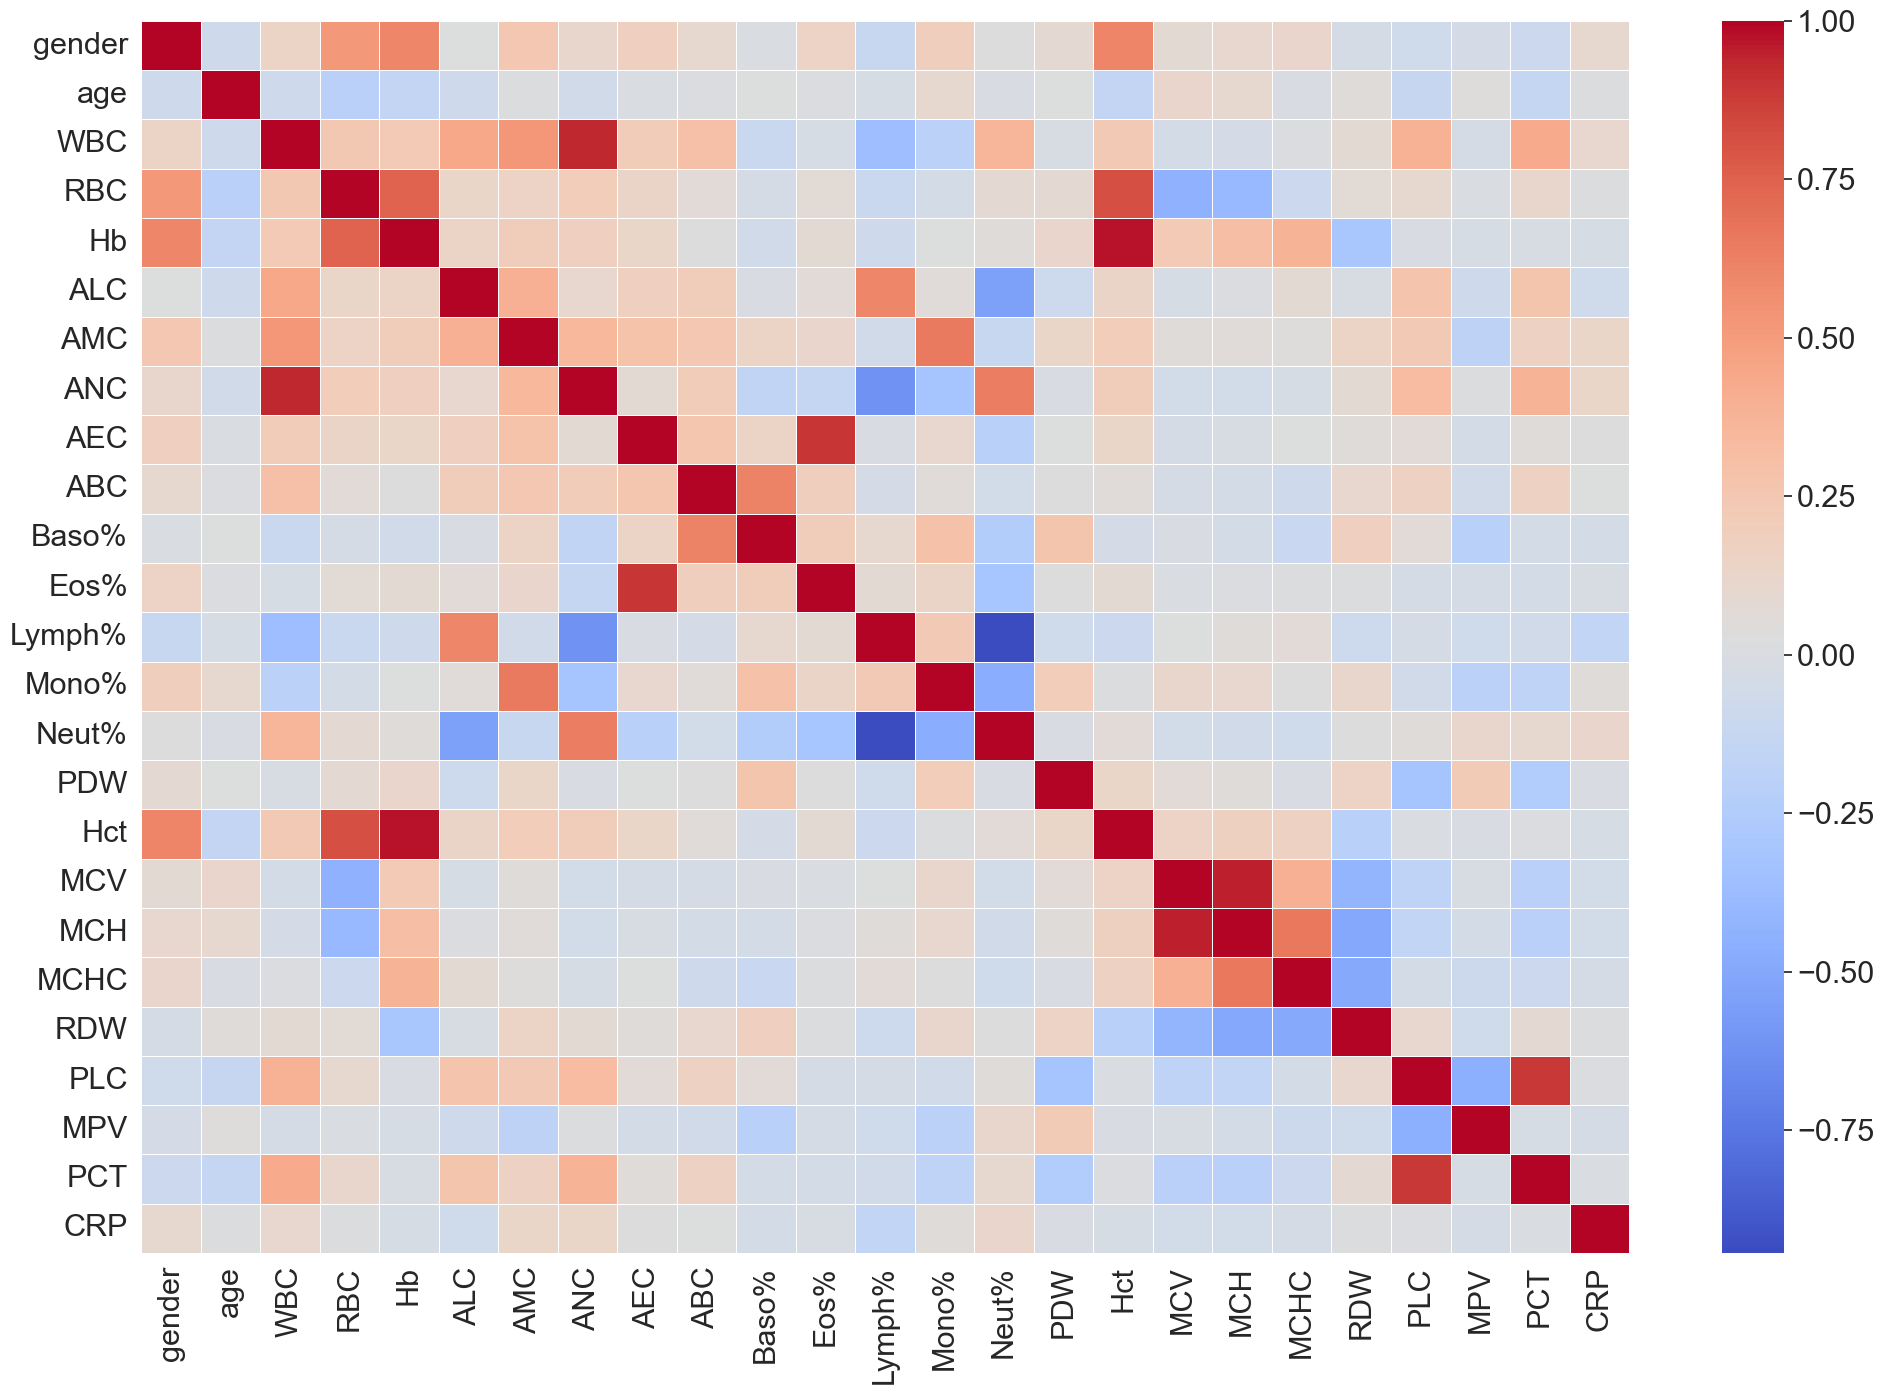

In [81]:
'''Heatmap'''
# Load data
data_v5 = pd.read_csv('20231230true_data.csv')  # Load data from a CSV file
print(BOLD + YELLOW +'True data:'+ RESET)  # Print a header
display(data_v5)  # Display the loaded data

# Define continuous columns for scaling
cols_to_scale = [1] + list(range(3, data_v5.shape[1]))  # Specify columns for Min-Max scaling

# Apply Min-Max Scaler
scaler = MinMaxScaler()  # Create a Min-Max Scaler object
data_v5.iloc[:, cols_to_scale] = scaler.fit_transform(data_v5.iloc[:, cols_to_scale])  # Scale selected columns
print(BOLD + YELLOW +'After Min-Max scaling:'+ RESET)  # Print a header
display(data_v5)  # Display the scaled data
data_v5.to_csv('machine learning data.csv', index=False)  # Save the scaled data to a new CSV file

# Compute correlation matrix
corr_to_scale=[0,1]+ list(range(3, data_v5.shape[1])) 
correlation_matrix = data_v5.iloc[:, corr_to_scale].corr()  # Calculate the correlation matrix

# Plot settings
print(BOLD + YELLOW +'Heatmap:'+ RESET)  # Print a header
sns.set(font_scale=2)  # Set the font scale for the heatmap
plt.figure(figsize=(24, 16))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)  # Create and display a heatmap
plt.show()  # Show the heatmap
# Uncomment to save the correlation matrix and heatmap
# correlation_matrix.to_csv('correlation_matrix.csv')
# plt.savefig('correlation_heatmap.jpg')

<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">5. Machine Learning</h2>

In [82]:
# Load data
data_v6 = pd.read_csv('machine learning data.csv')
# Separate target variable and features
y = data_v6['outcome']
X = data_v6.drop('outcome', axis=1)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
# Define a dictionary of classifiers with their respective instances
classifiers = {"Logistic Regression": LogisticRegression(),
               "Support Vector Machine": SVC(probability=True),
               "Stochastic Gradient Descent": SGDClassifier(loss='modified_huber',alpha=0.000001,penalty = 'l2',class_weight={0: 0.7, 1: 0.3}),
               "HistGradientBoostingClassifier": HistGradientBoostingClassifier(),
               "Random Forest": RandomForestClassifier(),
               "Naive Bayes": GaussianNB(),
               "Multilayer Perceptron": MLPClassifier(),
               "XGBoost": XGBClassifier(),
               "CatBoost": CatBoostClassifier(),
               "LightGBM": LGBMClassifier()}
results = pd.DataFrame()  # To store evaluation results
# Loop through each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    lr_fpr, lr_tpr, _ =roc_curve(y_test,y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # another name: sensitivity
    accuracy = accuracy_score(y_test, y_pred)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)  # f1: 2 tp / (2 tp + fp + fn)
    roc = roc_auc_score(y_test, y_pred_proba)
    ppv = tp / (tp + fp)  # Positive Predictive Value
    npv = tn / (tn + fn)  # Negative Predictive Value
    # Plot the ROC curve
    # Create a DataFrame from the dictionary and append to results
    results_list = pd.DataFrame({"Classifier": [clf_name],
                                 "ROC": [roc],
                                 "Sensitivity": [recall],
                                 "Specificity": [specificity],
                                 "F1": [f1],
                                 "Accuracy": [accuracy],
                                 "PPV": [ppv],
                                 "NPV": [npv]})
    results = pd.concat([results, results_list], ignore_index=True)

print(BOLD + YELLOW + 'Metric Results:' + RESET)
display(results)

Learning rate set to 0.010842
0:	learn: 0.6904653	total: 4.95ms	remaining: 4.94s
1:	learn: 0.6878829	total: 9.24ms	remaining: 4.61s
2:	learn: 0.6853089	total: 13.4ms	remaining: 4.44s
3:	learn: 0.6828055	total: 17.7ms	remaining: 4.41s
4:	learn: 0.6801820	total: 22.4ms	remaining: 4.46s
5:	learn: 0.6779688	total: 26.9ms	remaining: 4.45s
6:	learn: 0.6755862	total: 30.9ms	remaining: 4.38s
7:	learn: 0.6731434	total: 35.5ms	remaining: 4.41s
8:	learn: 0.6708355	total: 39.8ms	remaining: 4.38s
9:	learn: 0.6686393	total: 44ms	remaining: 4.36s
10:	learn: 0.6663632	total: 48.2ms	remaining: 4.34s
11:	learn: 0.6642572	total: 52.2ms	remaining: 4.3s
12:	learn: 0.6622948	total: 56ms	remaining: 4.25s
13:	learn: 0.6601277	total: 60ms	remaining: 4.23s
14:	learn: 0.6582132	total: 63.8ms	remaining: 4.19s
15:	learn: 0.6558356	total: 67.7ms	remaining: 4.16s
16:	learn: 0.6536877	total: 71.8ms	remaining: 4.15s
17:	learn: 0.6519590	total: 75.8ms	remaining: 4.13s
18:	learn: 0.6502726	total: 79.7ms	remaining: 4.12s

,Classifier,ROC,Sensitivity,Specificity,F1,Accuracy,PPV,NPV
0,Logistic Regression,0.585164,0.000000,1.000000,0.000000,0.790780,NaN,0.790780
1,Support Vector Machine,0.503990,0.000000,1.000000,0.000000,0.790780,NaN,0.790780
2,Stochastic Gradient Descent,0.490917,0.796610,0.165919,0.321918,0.297872,0.201717,0.755102
3,HistGradientBoostingClassifier,0.536977,0.169492,0.869955,0.204082,0.723404,0.256410,0.798354
4,Random Forest,0.514783,0.033898,0.973094,0.059701,0.776596,0.250000,0.791971
5,Naive Bayes,0.561678,0.271186,0.807175,0.271186,0.695035,0.271186,0.807175
6,Multilayer Perceptron,0.554686,0.000000,0.995516,0.000000,0.787234,0.000000,0.790036
7,XGBoost,0.478985,0.101695,0.883408,0.131868,0.719858,0.187500,0.788000
8,CatBoost,0.545793,0.033898,0.968610,0.058824,0.773050,0.222222,0.791209
9,LightGBM,0.524132,0.152542,0.874439,0.187500,0.723404,0.243243,0.795918


<h2 style="font-family: Times New Roman; font-size: 18px; font-style: normal; letter-spacing: 2px; background-color: #4CAF50; color: #FFFFFF; border-radius: 5px 5px; padding: 3px; text-align: left; font-weight: bold;">6. SHAP</h2>

In [83]:
# Load data
data_v7 = pd.read_csv('machine learning data.csv')

# Separate target variable and features
y = data_v7['outcome']
X = data_v7.drop('outcome', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train a model (you can choose one of the classifiers from your code)
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "Stochastic Gradient Descent": SGDClassifier(loss='modified_huber',alpha=0.000001,penalty = 'l2',class_weight={0: 0.7, 1: 0.3}),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Multilayer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(),
    "LightGBM": LGBMClassifier()
}

model = classifiers["Logistic Regression"]
model.fit(X_train, y_train)

# Create an explainer for the model
explainer = shap.Explainer(model, X_train)

shap_values = explainer.shap_values(X)
# Create a force plot for the first sample (you can change the sample index)
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# Use Matplotlib to save the force plot as an image (e.g., PNG)
shap.save_html('force_plot.html', force_plot)  # Save as an HTML file
webbrowser.open('force_plot.html')  # Opens the HTML file in the default web browser

True

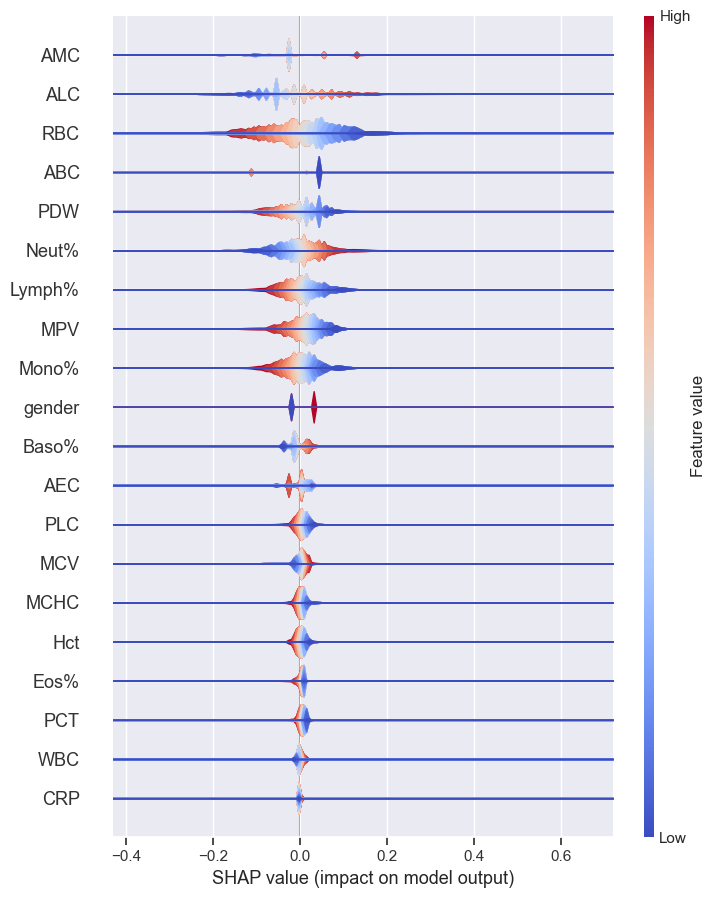

In [84]:
shap.summary_plot(
    shap_values[:1000, :],
    X.iloc[:1000, :],
    plot_type="layered_violin",
    color="coolwarm")

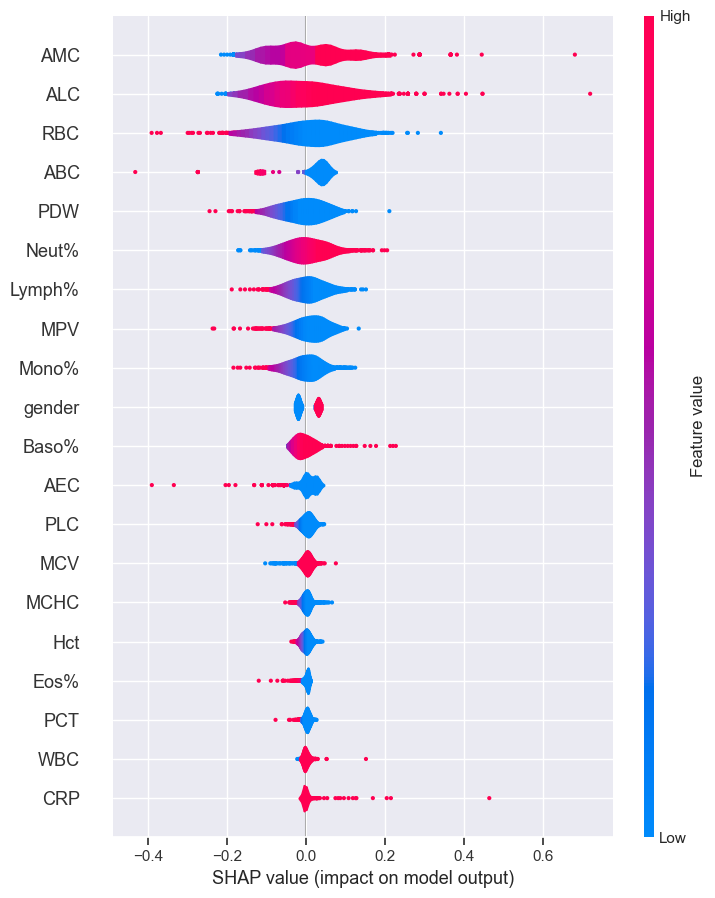

In [85]:
shap.summary_plot(shap_values[:1000, :], X.iloc[:1000, :], plot_type="violin")

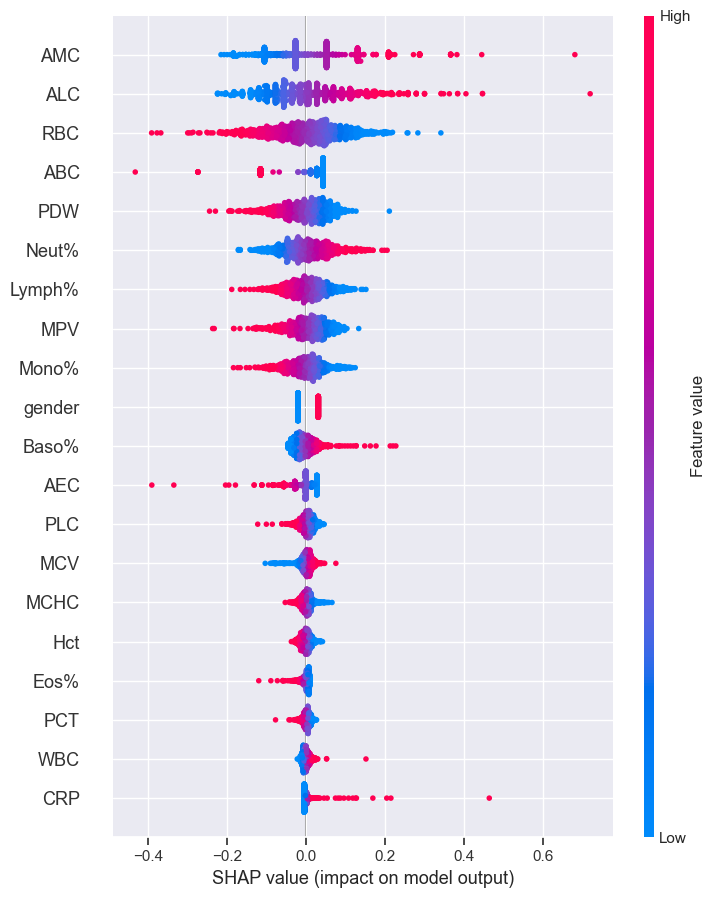

In [86]:
shap.summary_plot(shap_values[:1000, :], X.iloc[:1000, :])

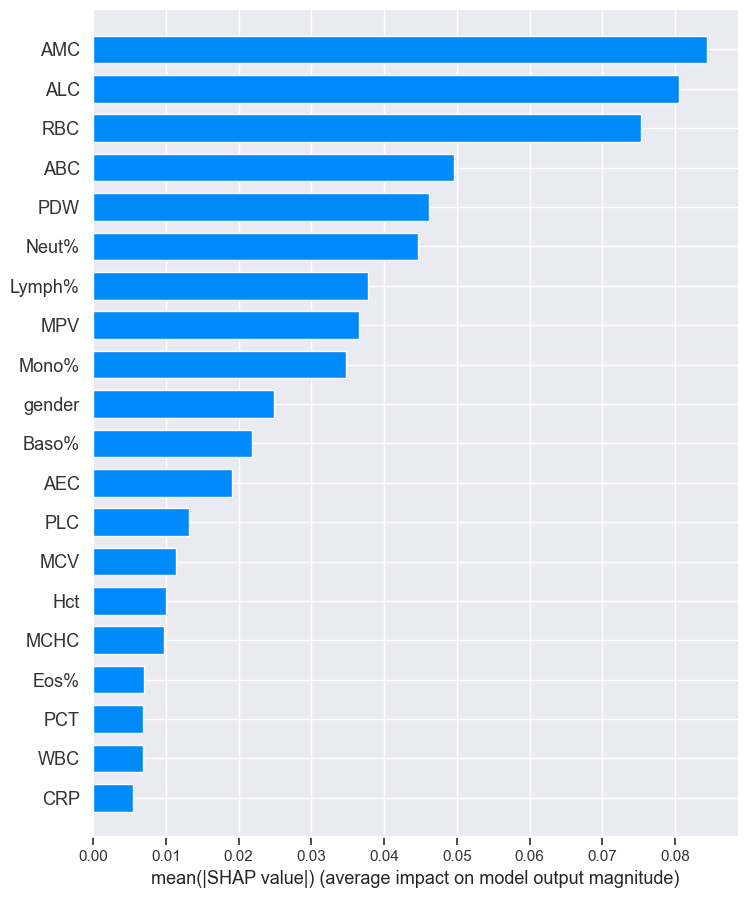

In [87]:
shap.summary_plot(shap_values, X, plot_type="bar")